In [2101]:
import eikon as ek
import numpy as np
import pandas as pd
import json
import datetime as dt
import traceback
import math

# Import Cleaned Data

In [2102]:
price_data = pd.read_csv("price_data_cleaned.csv")

In [2103]:
price_data.describe()

,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,C3 - Close Price,C3 - Accumulated Volume,C4 - Close Price,C4 - Accumulated Volume,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return
count,166554.000000,166554.000000,166554.000000,166554.000000,166554.000000,1.664290e+05,166554.000000,1.665070e+05,162312.000000,1.622760e+05,162312.000000,1.622760e+05,166554.000000,166554.000000,162726.000000,162726.000000
mean,2007.503032,6.555964,15.772128,2.014272,2247.252814,1.925024e+05,2248.873235,1.765483e+05,2290.334560,4.550426e+04,2290.334560,4.550426e+04,0.000187,0.000119,0.000135,0.000135
std,8.644937,3.433873,8.750959,1.399904,10215.661480,3.268517e+06,10218.444864,2.920270e+06,10305.344406,1.103189e+06,10305.344406,1.103189e+06,0.016653,0.015798,0.014556,0.014556
min,1992.000000,1.000000,1.000000,0.000000,-13.100000,0.000000e+00,0.302000,0.000000e+00,0.308000,0.000000e+00,0.308000,0.000000e+00,-0.359333,-0.941776,-0.261407,-0.261407
25%,2000.000000,4.000000,8.000000,1.000000,19.490000,7.530000e+02,19.430000,2.519000e+03,19.800000,9.200000e+02,19.800000,9.200000e+02,-0.006027,-0.005932,-0.005422,-0.005422
50%,2008.000000,7.000000,16.000000,2.000000,111.450000,4.979000e+03,111.700000,1.022200e+04,112.850000,4.084000e+03,112.850000,4.084000e+03,0.000000,0.000000,0.000000,0.000000
75%,2015.000000,10.000000,23.000000,3.000000,502.750000,2.227400e+04,506.875000,3.527050e+04,524.000000,1.610625e+04,524.000000,1.610625e+04,0.006370,0.006090,0.005732,0.005732
max,2021.000000,12.000000,31.000000,6.000000,155880.000000,1.734515e+08,154750.000000,2.790027e+08,154540.000000,1.340868e+08,154540.000000,1.340868e+08,0.479290,0.387716,0.409346,0.409346


# Create Carry Signals & Trading Data Set

In [2104]:
price_data["C1 - C2 Carry"] = price_data["C2 - Close Price"] / price_data["Close Price"] - 1

In [2105]:
price_data["Instrument - Lag"] = price_data.Instrument.shift(1)
price_data["Date - Lag"] = price_data.Date.shift(1)
price_data["C2 - Close Price - Lag"] = price_data["C2 - Close Price"].shift(1)
price_data["Close Price - Lag"] = price_data["Close Price"].shift(1)
price_data["C1 - C2 Carry - Lag"] = price_data["C1 - C2 Carry"].shift(1)

In [2106]:
price_data["Date - Lag"] = price_data[["Instrument - Lag", "Instrument", "Date - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C2 - Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "C2 - Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C1 - C2 Carry - Lag"] = price_data[["Instrument - Lag", "Instrument", "C1 - C2 Carry - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

In [2107]:
trading_data = price_data.copy()

In [2108]:
trading_data

,Instrument,Date,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,...,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return,C1 - C2 Carry,Instrument - Lag,Date - Lag,C2 - Close Price - Lag,Close Price - Lag,C1 - C2 Carry - Lag
0,SB,1992-01-03,1992,1,3,4,8.410,5154.0,8.370,3388.0,...,-0.020955,-0.018757,-0.012972,-0.012972,-0.004756,NaN,NaN,NaN,NaN,NaN
1,SB,1992-01-06,1992,1,6,0,8.500,4996.0,8.440,2751.0,...,0.010702,0.008363,0.003584,0.003584,-0.007059,SB,1992-01-03,8.370,8.410,-0.004756
2,SB,1992-01-07,1992,1,7,1,8.350,4846.0,8.320,4290.0,...,-0.017647,-0.014218,-0.007143,-0.007143,-0.003593,SB,1992-01-06,8.440,8.500,-0.007059
3,SB,1992-01-08,1992,1,8,2,8.430,5456.0,8.460,4665.0,...,0.009581,0.016827,0.014388,0.014388,0.003559,SB,1992-01-07,8.320,8.350,-0.003593
4,SB,1992-01-09,1992,1,9,3,8.450,4213.0,8.440,4566.0,...,0.002372,-0.002364,0.001182,0.001182,-0.001183,SB,1992-01-08,8.460,8.430,0.003559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,SI,2021-12-27,2021,12,27,0,22.680,1.0,23.060,108793.0,...,0.000000,0.000000,0.000000,0.000000,0.016755,SI,2021-12-23,22.895,22.835,0.002628
166550,SI,2021-12-28,2021,12,28,1,23.150,211.0,23.015,73451.0,...,0.000000,0.000000,0.000000,0.000000,-0.005832,SI,2021-12-27,23.060,22.680,0.016755
166551,SI,2021-12-29,2021,12,29,2,22.635,172.0,22.825,98976.0,...,0.000000,0.000000,0.000000,0.000000,0.008394,SI,2021-12-28,23.015,23.150,-0.005832
166552,SI,2021-12-30,2021,12,30,3,23.070,344.0,23.100,75359.0,...,0.000000,0.000000,0.000000,0.000000,0.001300,SI,2021-12-29,22.825,22.635,0.008394


In [2109]:
trading_data.Date = pd.to_datetime(trading_data.Date)

Value Baseline

To calculate the value factor we need the average price over the past 5 years. The average excludes the current date to prevent forward-looking bias

In [2110]:
trading_data.sort_values(["Instrument", "Date"], ascending=True, inplace=True)

trading_data["1Y Average Price"] = trading_data.groupby(
    "Instrument"
).rolling(
    "365d",
    on="Date",
    closed="neither"
)["Close Price"].mean().to_numpy()

trading_data["C2 - 1Y Average Price"] = trading_data.groupby(
    "Instrument"
).rolling(
    "365d",
    on="Date",
    closed="neither"
)["C2 - Close Price"].mean().to_numpy()

In [2111]:
min_dates = trading_data.groupby("Instrument").agg(
    min_date = ("Date", "min")
).reset_index()

trading_data = trading_data.merge(min_dates, how="left")

trading_data["1Y Average Price"] = trading_data[[
    "1Y Average Price",
    "Date",
    "min_date"
]].apply(
    lambda x: x[0] if (x[1] - x[2]) / np.timedelta64(1, 'D') > 365 else np.nan, axis=1
)
trading_data["C2 - 1Y Average Price"] = trading_data[[
    "C2 - 1Y Average Price",
    "Date",
    "min_date"
]].apply(
    lambda x: x[0] if (x[1] - x[2]) / np.timedelta64(1, 'D') > 365 else np.nan, axis=1
)

We trade on the first available trading day of every month

In [2112]:
trading_data["Daily Adjusted Return"] += 1
trading_data["C2 - Daily Adjusted Return"] += 1
trading_data["C3 - Daily Adjusted Return"] += 1
trading_data["C4 - Daily Adjusted Return"] += 1

In [2113]:
trading_data

,Instrument,Date,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,...,C4 - Daily Adjusted Return,C1 - C2 Carry,Instrument - Lag,Date - Lag,C2 - Close Price - Lag,Close Price - Lag,C1 - C2 Carry - Lag,1Y Average Price,C2 - 1Y Average Price,min_date
0,C,1992-01-03,1992,1,3,4,248.75,23080.0,254.25,5508.0,...,0.993301,0.022111,KW,NaN,NaN,NaN,NaN,NaN,NaN,1992-01-03
1,C,1992-01-06,1992,1,6,0,250.00,20980.0,256.00,4266.0,...,1.005780,0.024000,C,1992-01-03,254.25,248.75,0.022111,NaN,NaN,1992-01-03
2,C,1992-01-07,1992,1,7,1,249.75,11869.0,256.00,4310.0,...,1.001916,0.025025,C,1992-01-06,256.00,250.00,0.024000,NaN,NaN,1992-01-03
3,C,1992-01-08,1992,1,8,2,253.00,18428.0,259.75,4042.0,...,1.009560,0.026680,C,1992-01-07,256.00,249.75,0.025025,NaN,NaN,1992-01-03
4,C,1992-01-09,1992,1,9,3,252.50,20440.0,259.25,6553.0,...,1.001894,0.026733,C,1992-01-08,259.75,253.00,0.026680,NaN,NaN,1992-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,W,2021-12-27,2021,12,27,0,805.75,52917.0,810.00,12813.0,...,0.994419,0.005275,W,2021-12-23,819.00,815.25,0.004600,699.814516,704.992944,1992-01-03
166550,W,2021-12-28,2021,12,28,1,784.00,64228.0,789.50,11353.0,...,0.977237,0.007015,W,2021-12-27,810.00,805.75,0.005275,700.584677,705.778226,1992-01-03
166551,W,2021-12-29,2021,12,29,2,789.25,78959.0,793.00,11679.0,...,1.003510,0.004751,W,2021-12-28,789.50,784.00,0.007015,701.248992,706.460685,1992-01-03
166552,W,2021-12-30,2021,12,30,3,780.50,74145.0,783.50,13878.0,...,0.985692,0.003844,W,2021-12-29,793.00,789.25,0.004751,701.852823,707.088710,1992-01-03


In [2114]:
backtest_data = trading_data.sort_values(
    by="Date",
    ascending=True
).groupby([
    "Instrument", "Year", "Month"
]).agg(
    Day = ("Day", "first"),
    date = ("Date", "first"),
    close_price_lag = ("Close Price - Lag", "first"),
    c2_close_price_lag = ("C2 - Close Price - Lag", "first"),
    c1_c2_carry_signal = ("C1 - C2 Carry - Lag", "first"),
    adj_monthly_return = ("Daily Adjusted Return", "prod"),
    c2_adj_monthly_return = ("C2 - Daily Adjusted Return", "prod"),
    adj_monthly_var = ("Daily Adjusted Return", np.std),
    c2_adj_monthly_var = ("C2 - Daily Adjusted Return", np.std),
    y1_mean_price = ("1Y Average Price", "first"),
    c2_y1_mean_price = ("C2 - 1Y Average Price", "first")
).reset_index()

In [2115]:
backtest_data["momentum_signal"] = (backtest_data.groupby("Instrument").adj_monthly_return.shift(1) - 1) / backtest_data.groupby("Instrument").adj_monthly_var.shift(1)

backtest_data["value_signal"] = np.log(backtest_data.groupby("Instrument")["y1_mean_price"].shift(4*12+6) / backtest_data["close_price_lag"])

backtest_data["c2_momentum_signal"] = (backtest_data.groupby("Instrument").c2_adj_monthly_return.shift(1) - 1) / backtest_data.groupby("Instrument").c2_adj_monthly_var.shift(1)

backtest_data["c2_value_signal"] = np.log(backtest_data.groupby("Instrument")["c2_y1_mean_price"].shift(4*12+6) / backtest_data["c2_close_price_lag"])

# We only drop NA values for carry & signal now as dropping value would incur a hefty loss in the amount of data
backtest_data.dropna(
    subset=[
        "c1_c2_carry_signal",
        "momentum_signal",
        "c2_momentum_signal"
    ],
    inplace=True
)

In [2116]:
backtest_data

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,y1_mean_price,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal
1,C,1992,2,3,1992-02-03,264.00,270.25,0.023674,1.002841,1.013876,0.010022,0.011309,NaN,NaN,7.210539,NaN,7.237623,NaN
2,C,1992,3,2,1992-03-02,264.75,274.00,0.034939,1.020887,1.004501,0.007213,0.007605,NaN,NaN,0.283455,NaN,1.226960,NaN
3,C,1992,4,1,1992-04-01,264.00,269.25,0.019886,0.923295,0.927577,0.008083,0.008303,NaN,NaN,2.895649,NaN,0.591895,NaN
4,C,1992,5,1,1992-05-01,243.75,249.75,0.024615,1.054299,1.052023,0.012753,0.011620,NaN,NaN,-9.489053,NaN,-8.722805,NaN
5,C,1992,6,1,1992-06-01,259.50,264.00,0.017341,0.957611,0.959280,0.013771,0.014253,NaN,NaN,4.257707,NaN,4.476899,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,0.017681,0.017467,626.326613,629.095766,-5.260120,-0.487450,-5.226479,-0.467118
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,0.012899,0.012722,644.916331,648.138105,0.261281,-0.495544,0.903645,-0.484742
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,0.014990,0.014640,657.928427,661.548387,-1.742975,-0.529955,-1.901552,-0.507432
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,0.018993,0.018696,669.581653,674.126008,4.343118,-0.602484,4.498064,-0.579011


Basis-Momentum Signal

In [2117]:
backtest_data["c1_c2_basis_momentum_signal"]  = backtest_data.close_price_lag / backtest_data.groupby("Instrument").close_price_lag.shift(12) \
    - backtest_data.c2_close_price_lag / backtest_data.groupby("Instrument").c2_close_price_lag.shift(12)

In [2118]:
backtest_data

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,y1_mean_price,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal
1,C,1992,2,3,1992-02-03,264.00,270.25,0.023674,1.002841,1.013876,0.010022,0.011309,NaN,NaN,7.210539,NaN,7.237623,NaN,NaN
2,C,1992,3,2,1992-03-02,264.75,274.00,0.034939,1.020887,1.004501,0.007213,0.007605,NaN,NaN,0.283455,NaN,1.226960,NaN,NaN
3,C,1992,4,1,1992-04-01,264.00,269.25,0.019886,0.923295,0.927577,0.008083,0.008303,NaN,NaN,2.895649,NaN,0.591895,NaN,NaN
4,C,1992,5,1,1992-05-01,243.75,249.75,0.024615,1.054299,1.052023,0.012753,0.011620,NaN,NaN,-9.489053,NaN,-8.722805,NaN,NaN
5,C,1992,6,1,1992-06-01,259.50,264.00,0.017341,0.957611,0.959280,0.013771,0.014253,NaN,NaN,4.257707,NaN,4.476899,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,0.017681,0.017467,626.326613,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,0.012899,0.012722,644.916331,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,0.014990,0.014640,657.928427,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,0.018993,0.018696,669.581653,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226


## Carry Strategies

Rank the carries for each month so we can get the top & bottom percentiles

In [2119]:
backtest_data["Carry Rank"] = backtest_data.groupby(["Year", "Month"])["c1_c2_carry_signal"].rank("average", ascending=True,pct=True )

In [2120]:
backtest_data

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,y1_mean_price,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,Carry Rank
1,C,1992,2,3,1992-02-03,264.00,270.25,0.023674,1.002841,1.013876,0.010022,0.011309,NaN,NaN,7.210539,NaN,7.237623,NaN,NaN,0.842105
2,C,1992,3,2,1992-03-02,264.75,274.00,0.034939,1.020887,1.004501,0.007213,0.007605,NaN,NaN,0.283455,NaN,1.226960,NaN,NaN,0.894737
3,C,1992,4,1,1992-04-01,264.00,269.25,0.019886,0.923295,0.927577,0.008083,0.008303,NaN,NaN,2.895649,NaN,0.591895,NaN,NaN,0.789474
4,C,1992,5,1,1992-05-01,243.75,249.75,0.024615,1.054299,1.052023,0.012753,0.011620,NaN,NaN,-9.489053,NaN,-8.722805,NaN,NaN,0.950000
5,C,1992,6,1,1992-06-01,259.50,264.00,0.017341,0.957611,0.959280,0.013771,0.014253,NaN,NaN,4.257707,NaN,4.476899,NaN,NaN,0.842105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,0.017681,0.017467,626.326613,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.703704
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,0.012899,0.012722,644.916331,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.851852
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,0.014990,0.014640,657.928427,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.851852
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,0.018993,0.018696,669.581653,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.851852


In [2121]:
backtest_data[backtest_data["Carry Rank"] >= 2/3].c2_adj_monthly_return.product() - 1

-0.9997328415248407

In [2122]:
backtest_data[backtest_data["Carry Rank"] <= 1/3].c2_adj_monthly_return.product() - 1

98.01745021846428

Positive Carry Test

In [2123]:
positive_carry_test = backtest_data[
    backtest_data["Carry Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [2124]:
positive_carry_test["x"] = positive_carry_test["Year"] + (positive_carry_test["Month"] - 1) / 12

In [2125]:
positive_carry_test[["x", "y"]]

,x,y
0,1992.083333,0.970561
1,1992.166667,1.008021
2,1992.250000,0.977645
3,1992.333333,1.007000
4,1992.416667,0.994948
...,...,...
354,2021.583333,1.045636
355,2021.666667,0.974312
356,2021.750000,1.026724
357,2021.833333,1.009064


In [2126]:
positive_carry_test["y_cum"] = (2 - positive_carry_test["y"]).cumprod()

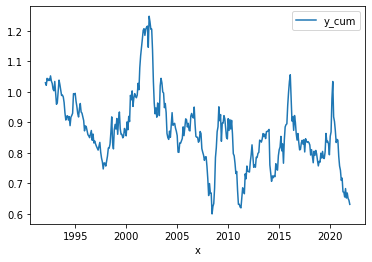

In [2127]:
positive_carry_test.plot.line(x="x", y="y_cum")

In [2128]:
positive_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.000549
std,0.038419
min,0.854508
25%,0.977397
50%,1.003409
75%,1.023405
max,1.133004


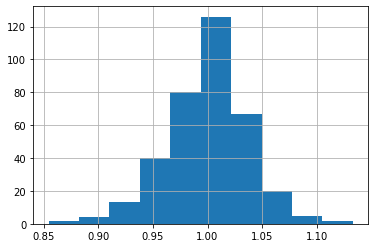

In [2129]:
positive_carry_test["y"].hist()

Negative Carry Test

In [2130]:
negative_carry_test = backtest_data[(backtest_data["Carry Rank"] <= 1/3)].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [2131]:
negative_carry_test["x"] = negative_carry_test["Year"] + (negative_carry_test["Month"] - 1) / 12

In [2132]:
negative_carry_test[["x", "y"]]

,x,y
0,1992.083333,0.999899
1,1992.166667,0.992977
2,1992.250000,0.986872
3,1992.333333,1.044906
4,1992.416667,1.010671
...,...,...
354,2021.583333,0.980413
355,2021.666667,1.041894
356,2021.750000,1.005262
357,2021.833333,0.955206


In [2133]:
negative_carry_test["y_cum"] = negative_carry_test["y"].cumprod()

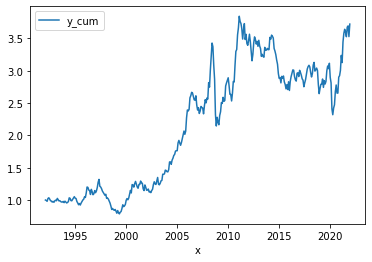

In [2134]:
negative_carry_test.plot.line(x="x", y="y_cum")

In [2135]:
negative_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.004411
std,0.038589
min,0.810273
25%,0.979342
50%,1.000758
75%,1.027921
max,1.117043


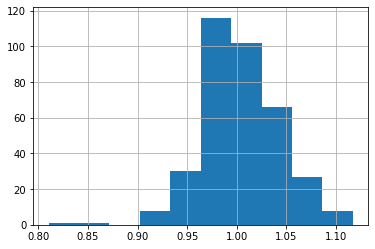

In [2136]:
negative_carry_test["y"].hist()

Combined Carry Test

In [2137]:
combined_carry_test = positive_carry_test[["x", "y"]].merge(negative_carry_test[["x", "y"]], on="x")

In [2138]:
combined_carry_test["y"] = (2 - combined_carry_test["y_x"] + combined_carry_test["y_y"]) / 2

In [2139]:
combined_carry_test[["x", "y"]]

,x,y
0,1992.083333,1.014669
1,1992.166667,0.992478
2,1992.250000,1.004614
3,1992.333333,1.018953
4,1992.416667,1.007861
...,...,...
354,2021.583333,0.967389
355,2021.666667,1.033791
356,2021.750000,0.989269
357,2021.833333,0.973071


In [2140]:
combined_carry_test["y_cum"] = combined_carry_test["y"].cumprod()

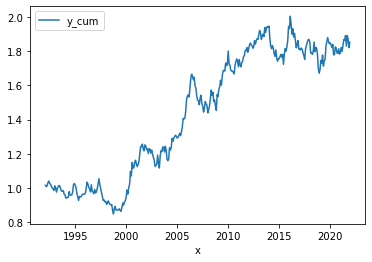

In [2141]:
combined_carry_test.plot.line(x="x", y="y_cum")

In [2142]:
combined_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.001931
std,0.020757
min,0.952460
25%,0.987857
50%,1.000337
75%,1.014353
max,1.075004


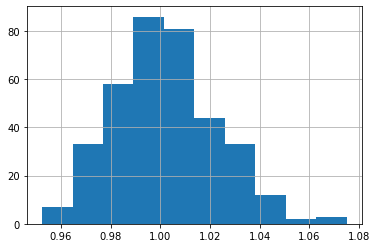

In [2143]:
combined_carry_test["y"].hist()

Equal Weighted Long Commodity Test

In [2144]:
ew_commodity_test = backtest_data.groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [2145]:
ew_commodity_test["x"] = ew_commodity_test["Year"] + (ew_commodity_test["Month"] - 1) / 12

In [2146]:
ew_commodity_test[["x", "y"]]

,x,y
0,1992.083333,0.987582
1,1992.166667,1.002805
2,1992.250000,0.995651
3,1992.333333,1.024674
4,1992.416667,1.006917
...,...,...
354,2021.583333,1.005498
355,2021.666667,1.007544
356,2021.750000,1.011736
357,2021.833333,0.993376


In [2147]:
ew_commodity_test["y_cum"] = ew_commodity_test["y"].cumprod()

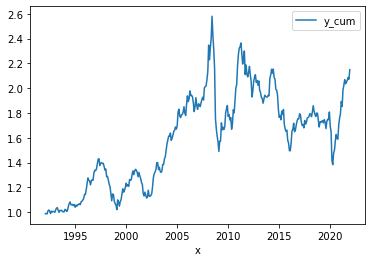

In [2148]:
ew_commodity_test.plot.line(x="x", y="y_cum")

In [2149]:
ew_commodity_test[["y"]].describe()

,y
count,359.000000
mean,1.002632
std,0.031397
min,0.815559
25%,0.983788
50%,1.004036
75%,1.019773
max,1.100172


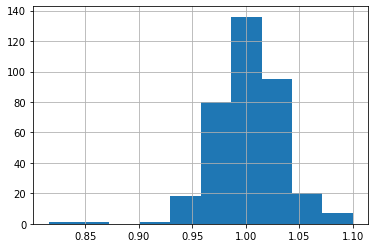

In [2150]:
ew_commodity_test["y"].hist()

Look into the different percentiles and their return characteristics

In [2151]:
backtest_data["Carry Rank Group"] = backtest_data["Carry Rank"].apply(lambda x: math.floor(x*10))

In [2152]:
backtest_data.groupby("Carry Rank Group").agg(
    mean_return = ("c2_adj_monthly_return", "mean"),
    med_return = ("c2_adj_monthly_return", "mean"),
    min_return = ("c2_adj_monthly_return", "min"),
    max_return = ("c2_adj_monthly_return", "max"),
    std_return = ("c2_adj_monthly_return", "std")
)

,mean_return,med_return,min_return,max_return,std_return
Carry Rank Group,,,,,
0,1.004874,1.004874,0.720833,1.366957,0.076015
1,0.999441,0.999441,0.567803,1.318148,0.069635
2,1.007582,1.007582,0.625466,1.550507,0.073298
3,1.003364,1.003364,0.661273,1.313360,0.066876
4,1.002334,1.002334,0.697743,1.245527,0.065582
5,1.002898,1.002898,0.715061,1.372080,0.067490
6,1.005914,1.005914,0.449966,1.343601,0.071876
7,1.002591,1.002591,0.740697,1.367135,0.072594
8,0.997799,0.997799,0.794677,1.416961,0.069655


## Momentum Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [2153]:
backtest_data["c1_c2_momentum_signal"] = (backtest_data["momentum_signal"] + backtest_data["c2_momentum_signal"]) / 2
backtest_data["Momentum Rank"] = backtest_data.groupby(["Year", "Month"])["c1_c2_momentum_signal"].rank("average", ascending=True,pct=True)

In [2154]:
backtest_data[backtest_data["Momentum Rank"] >= 2/3].c2_adj_monthly_return.product() - 1

89.11968908419607

In [2155]:
backtest_data[backtest_data["Momentum Rank"] <= 1/3].c2_adj_monthly_return.product() - 1

-0.998828980491889

Positive Momentum Test

In [2156]:
positive_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("adj_monthly_return", "mean")).reset_index()

In [2157]:
positive_momentum_test["x"] = positive_momentum_test["Year"] + (positive_momentum_test["Month"] - 1) / 12

In [2158]:
positive_momentum_test[["x", "y"]]

,x,y
0,1992.083333,0.981155
1,1992.166667,1.032154
2,1992.250000,1.061608
3,1992.333333,1.063997
4,1992.416667,1.002342
...,...,...
354,2021.583333,1.017667
355,2021.666667,0.995150
356,2021.750000,1.004274
357,2021.833333,0.985823


In [2159]:
positive_momentum_test["y_cum"] = positive_momentum_test["y"].cumprod()

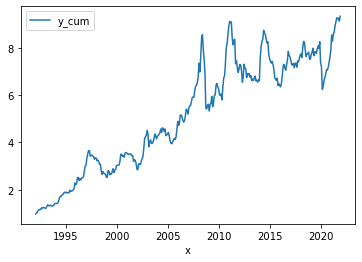

In [2160]:
positive_momentum_test.plot.line(x="x", y="y_cum")

In [2161]:
positive_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.007092
std,0.041152
min,0.786578
25%,0.986020
50%,1.007404
75%,1.027107
max,1.152199


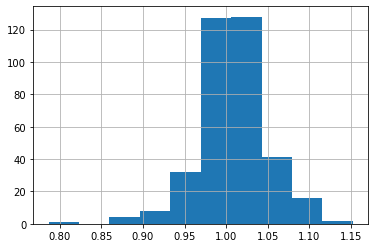

In [2162]:
positive_momentum_test["y"].hist()

Negative Momentum Test

In [2163]:
negative_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] <= 1/3
].groupby(["Year", "Month"]).agg(y = ("adj_monthly_return", "mean")).reset_index()

In [2164]:
negative_momentum_test["x"] = negative_momentum_test["Year"] + (negative_momentum_test["Month"] - 1) / 12

In [2165]:
negative_momentum_test[["x", "y"]]

,x,y
0,1992.083333,0.986055
1,1992.166667,1.002746
2,1992.250000,0.982796
3,1992.333333,0.997278
4,1992.416667,1.043439
...,...,...
354,2021.583333,1.008900
355,2021.666667,0.994908
356,2021.750000,1.018235
357,2021.833333,0.971956


In [2166]:
negative_momentum_test["y_cum"] = (2 - negative_momentum_test["y"]).cumprod()

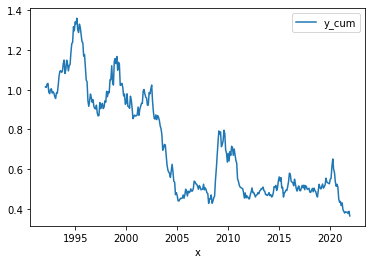

In [2167]:
negative_momentum_test.plot.line(x="x", y="y_cum")

In [2168]:
negative_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.001934
std,0.041903
min,0.826897
25%,0.976924
50%,1.003472
75%,1.026905
max,1.126087


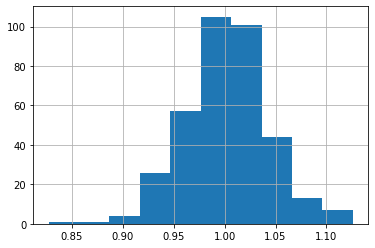

In [2169]:
negative_momentum_test["y"].hist()

Combined Momentum Test

In [2170]:
combined_momentum_test = negative_momentum_test[["x", "y"]].merge(positive_momentum_test[["x", "y"]], on="x")

In [2171]:
combined_momentum_test["y"] = (2 - combined_momentum_test["y_x"] + combined_momentum_test["y_y"]) / 2

In [2172]:
combined_momentum_test[["x", "y"]]

,x,y
0,1992.083333,0.997550
1,1992.166667,1.014704
2,1992.250000,1.039406
3,1992.333333,1.033360
4,1992.416667,0.979451
...,...,...
354,2021.583333,1.004383
355,2021.666667,1.000121
356,2021.750000,0.993019
357,2021.833333,1.006934


In [2173]:
combined_momentum_test["y_cum"] = combined_momentum_test["y"].cumprod()

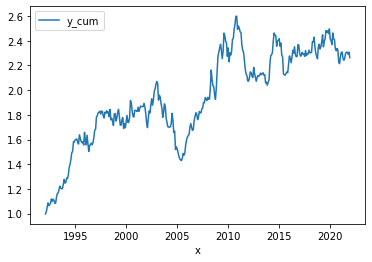

In [2174]:
combined_momentum_test.plot.line(x="x", y="y_cum")

In [2175]:
combined_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.002579
std,0.024602
min,0.910746
25%,0.987995
50%,1.001422
75%,1.017386
max,1.078956


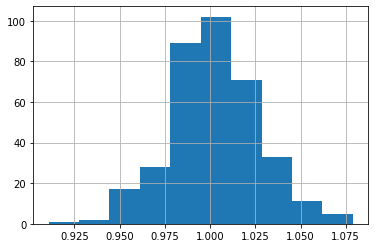

In [2176]:
combined_momentum_test["y"].hist()

## Carry-Momentum V3
Rather than optimizing carry with momentum, we optimize momentum with carry

Negative Momentum-Carry Test

In [2177]:
negative_momentum_carry_v3_test = backtest_data[
    (backtest_data["Momentum Rank"] <= 1/3)
].copy()
negative_momentum_carry_v3_test["pick_adj_monthly_return"] = negative_momentum_carry_v3_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)
negative_momentum_carry_v3_test = negative_momentum_carry_v3_test.groupby(["Year", "Month"]).agg(y = ("pick_adj_monthly_return", "mean")).reset_index()

In [2178]:
negative_momentum_carry_v3_test["x"] = negative_momentum_carry_v3_test["Year"] + (negative_momentum_carry_v3_test["Month"] - 1) / 12

In [2179]:
negative_momentum_carry_v3_test = negative_momentum_carry_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
negative_momentum_carry_v3_test.fillna(1, inplace=True)
negative_momentum_carry_v3_test.sort_values(by="x", inplace=True)

In [2180]:
negative_momentum_carry_v3_test[["x", "y"]]

,x,y
0,1992.083333,0.973007
1,1992.166667,1.001992
2,1992.250000,0.982722
3,1992.333333,0.996871
4,1992.416667,1.031182
...,...,...
354,2021.583333,1.008222
355,2021.666667,0.995705
356,2021.750000,1.014796
357,2021.833333,0.975646


In [2181]:
negative_momentum_carry_v3_test["y_cum"] = (2 - negative_momentum_carry_v3_test["y"]).cumprod()

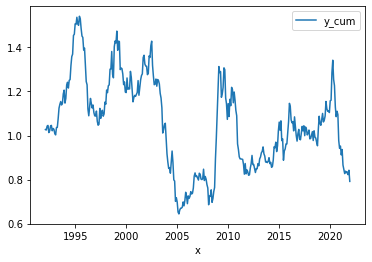

In [2182]:
negative_momentum_carry_v3_test.plot.line(x="x", y="y_cum")

In [2183]:
negative_momentum_carry_v3_test[["y"]].describe()

,y
count,359.000000
mean,0.999826
std,0.040648
min,0.830188
25%,0.975612
50%,0.999420
75%,1.025288
max,1.117109


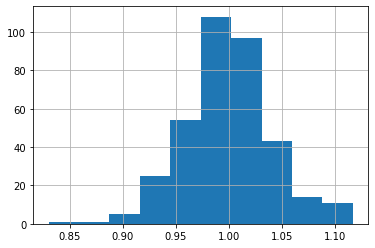

In [2184]:
negative_momentum_carry_v3_test["y"].hist()

Positive Momentum-Carry Test

In [2185]:
positive_momentum_carry_v3_test = backtest_data[
    (backtest_data["Momentum Rank"] >= 2/3)
].copy()
positive_momentum_carry_v3_test["pick_adj_monthly_return"] = positive_momentum_carry_v3_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)
positive_momentum_carry_v3_test = positive_momentum_carry_v3_test.groupby(["Year", "Month"]).agg(y = ("pick_adj_monthly_return", "mean")).reset_index()

In [2186]:
positive_momentum_carry_v3_test["x"] = positive_momentum_carry_v3_test["Year"] + (positive_momentum_carry_v3_test["Month"] - 1) / 12

In [2187]:
positive_momentum_carry_v3_test = positive_momentum_carry_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
positive_momentum_carry_v3_test.fillna(1, inplace=True)
positive_momentum_carry_v3_test.sort_values(by="x", inplace=True)

In [2188]:
positive_momentum_carry_v3_test[["x", "y"]]

,x,y
0,1992.083333,1.015966
1,1992.166667,1.032154
2,1992.250000,1.045401
3,1992.333333,1.049480
4,1992.416667,1.000193
...,...,...
354,2021.583333,1.014124
355,2021.666667,0.996984
356,2021.750000,0.998075
357,2021.833333,0.986423


In [2189]:
positive_momentum_carry_v3_test["y_cum"] = positive_momentum_carry_v3_test["y"].cumprod()

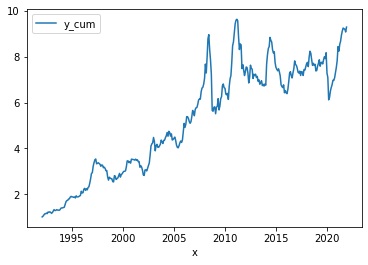

In [2190]:
positive_momentum_carry_v3_test.plot.line(x="x", y="y_cum")

In [2191]:
positive_momentum_carry_v3_test[["y"]].describe()

,y
count,359.000000
mean,1.007042
std,0.040213
min,0.782157
25%,0.985468
50%,1.008275
75%,1.029232
max,1.134672


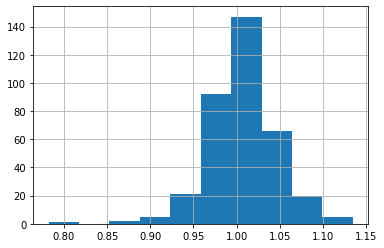

In [2192]:
positive_momentum_carry_v3_test["y"].hist()

Combined Carry Momentum Test

In [2193]:
combined_carry_momentum_v3_test = negative_momentum_carry_v3_test[["x", "y"]].merge(positive_momentum_carry_v3_test[["x", "y"]], on="x", how="outer")

In [2194]:
combined_carry_momentum_v3_test = combined_carry_momentum_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
combined_carry_momentum_v3_test.fillna(1, inplace=True)
combined_carry_momentum_v3_test.sort_values(by="x", inplace=True)

In [2195]:
combined_carry_momentum_v3_test["y"] = (2 - combined_carry_momentum_v3_test["y_x"] + combined_carry_momentum_v3_test["y_y"]) / 2

In [2196]:
combined_carry_momentum_v3_test[["x", "y"]]

,x,y
0,1992.083333,1.021479
1,1992.166667,1.015081
2,1992.250000,1.031340
3,1992.333333,1.026305
4,1992.416667,0.984505
...,...,...
354,2021.583333,1.002951
355,2021.666667,1.000640
356,2021.750000,0.991639
357,2021.833333,1.005389


In [2197]:
combined_carry_momentum_v3_test["y_cum"] = combined_carry_momentum_v3_test["y"].cumprod()

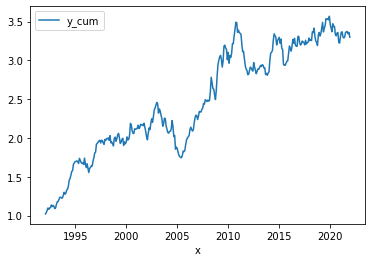

In [2198]:
combined_carry_momentum_v3_test.plot.line(x="x", y="y_cum")

In [2199]:
combined_carry_momentum_v3_test[["y"]].describe()

,y
count,359.000000
mean,1.003608
std,0.023631
min,0.912757
25%,0.989237
50%,1.003567
75%,1.017395
max,1.074088


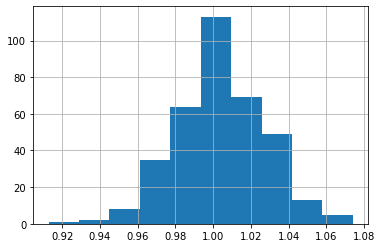

In [2200]:
combined_carry_momentum_v3_test["y"].hist()

## Basis-Momentum Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [2201]:
backtest_data_basis_momentum = backtest_data[~pd.isnull(backtest_data.c1_c2_basis_momentum_signal)].copy()

In [2202]:
backtest_data_basis_momentum

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,Carry Rank,Carry Rank Group,c1_c2_momentum_signal,Momentum Rank
13,C,1993,2,1,1993-02-01,214.50,222.25,0.036131,0.983683,0.986502,...,240.141434,-1.634837,NaN,-1.320033,NaN,-0.009887,0.947368,9,-1.477435,0.263158
14,C,1993,3,1,1993-03-01,211.00,219.25,0.039100,1.080047,1.069305,...,236.237052,-3.966922,NaN,-4.005884,NaN,-0.003204,0.900000,9,-3.986403,0.200000
15,C,1993,4,1,1993-04-01,230.00,235.50,0.023913,0.993478,0.988323,...,231.908367,11.072632,NaN,6.609377,NaN,-0.003440,0.800000,8,8.841005,1.000000
16,C,1993,5,3,1993-05-03,228.50,232.75,0.018600,0.994679,0.987121,...,230.065476,-0.714555,NaN,-1.227507,NaN,0.005504,0.900000,9,-0.971031,0.500000
17,C,1993,6,1,1993-06-01,224.50,229.50,0.022272,0.992205,0.997821,...,227.715278,-0.551086,NaN,-1.441430,NaN,-0.004193,0.850000,8,-0.996258,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.703704,7,-5.243299,0.111111
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.851852,8,0.582463,0.555556
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.851852,8,-1.822264,0.481481
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.851852,8,4.420591,0.740741


In [2203]:
backtest_data_basis_momentum["Basis-Momentum Rank"] = backtest_data_basis_momentum.groupby(["Year", "Month"])["c1_c2_basis_momentum_signal"].rank("average", ascending=True,pct=True)

In [2204]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3].adj_monthly_return.product() - 1

267918.1459640176

In [2205]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] <= 2/3].adj_monthly_return.product() - 1

-0.994664257876897

Positive Momentum Test

In [2206]:
positive_basis_momentum_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("adj_monthly_return", "mean")).reset_index()

In [2207]:
positive_basis_momentum_test["x"] = positive_basis_momentum_test["Year"] + (positive_basis_momentum_test["Month"] - 1) / 12

In [2208]:
positive_basis_momentum_test[["x", "y"]]

,x,y
0,1993.083333,1.028002
1,1993.166667,0.999112
2,1993.250000,1.045604
3,1993.333333,0.941280
4,1993.416667,0.987620
...,...,...
342,2021.583333,1.001686
343,2021.666667,1.038310
344,2021.750000,1.027688
345,2021.833333,0.971770


In [2209]:
positive_basis_momentum_test["y_cum"] = positive_basis_momentum_test["y"].cumprod()

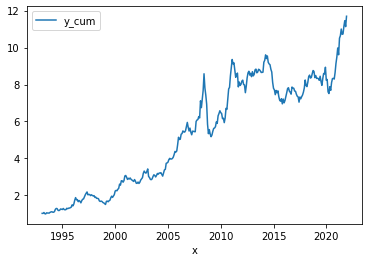

In [2210]:
positive_basis_momentum_test.plot.line(x="x", y="y_cum")

In [2211]:
positive_basis_momentum_test[["y"]].describe()

,y
count,347.000000
mean,1.007913
std,0.040260
min,0.842811
25%,0.981636
50%,1.005857
75%,1.033120
max,1.149267


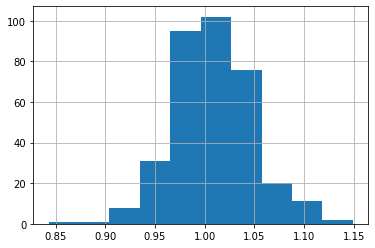

In [2212]:
positive_basis_momentum_test["y"].hist()

Negative Momentum Test

In [2213]:
negative_basis_momentum_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] <= 1/3
].groupby(["Year", "Month"]).agg(y = ("adj_monthly_return", "mean")).reset_index()

In [2214]:
negative_basis_momentum_test["x"] = negative_basis_momentum_test["Year"] + (negative_basis_momentum_test["Month"] - 1) / 12

In [2215]:
negative_basis_momentum_test[["x", "y"]]

,x,y
0,1993.083333,1.036301
1,1993.166667,1.029843
2,1993.250000,0.986971
3,1993.333333,0.965458
4,1993.416667,0.951654
...,...,...
342,2021.583333,1.026253
343,2021.666667,0.988420
344,2021.750000,0.982835
345,2021.833333,0.993945


In [2216]:
negative_basis_momentum_test["y_cum"] = (2 - negative_basis_momentum_test["y"]).cumprod()

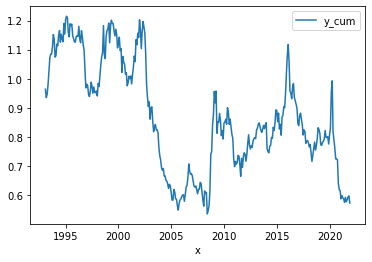

In [2217]:
negative_basis_momentum_test.plot.line(x="x", y="y_cum")

In [2218]:
negative_basis_momentum_test[["y"]].describe()

,y
count,347.000000
mean,1.000789
std,0.040516
min,0.793621
25%,0.977848
50%,1.002515
75%,1.023984
max,1.178792


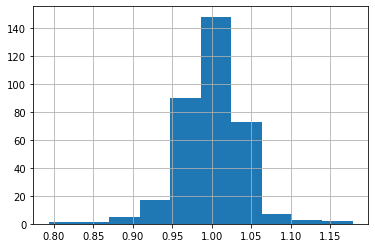

In [2219]:
negative_basis_momentum_test["y"].hist()

Combined Momentum Test

In [2220]:
combined_basis_momentum_test = negative_basis_momentum_test[["x", "y"]].merge(positive_basis_momentum_test[["x", "y"]], on="x")

In [2221]:
combined_basis_momentum_test["y"] = (2 - combined_basis_momentum_test["y_x"] + combined_basis_momentum_test["y_y"]) / 2

In [2222]:
combined_basis_momentum_test[["x", "y"]]

,x,y
0,1993.083333,0.995850
1,1993.166667,0.984634
2,1993.250000,1.029316
3,1993.333333,0.987911
4,1993.416667,1.017983
...,...,...
342,2021.583333,0.987717
343,2021.666667,1.024945
344,2021.750000,1.022427
345,2021.833333,0.988912


In [2223]:
combined_basis_momentum_test["y_cum"] = combined_basis_momentum_test["y"].cumprod()

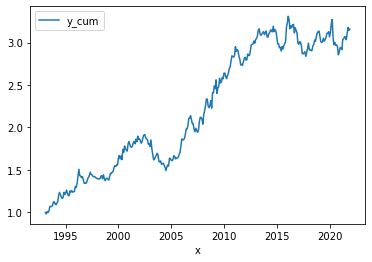

In [2224]:
combined_basis_momentum_test.plot.line(x="x", y="y_cum")

In [2225]:
combined_basis_momentum_test[["y"]].describe()

,y
count,347.000000
mean,1.003562
std,0.022094
min,0.935224
25%,0.988881
50%,1.002306
75%,1.015925
max,1.082390


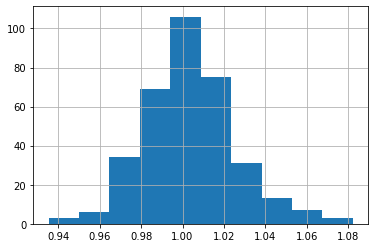

In [2226]:
combined_basis_momentum_test["y"].hist()

## Basis-Momentum-Carry Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [2227]:
backtest_data_basis_momentum = backtest_data[~pd.isnull(backtest_data.c1_c2_basis_momentum_signal)].copy()

In [2228]:
backtest_data_basis_momentum

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,Carry Rank,Carry Rank Group,c1_c2_momentum_signal,Momentum Rank
13,C,1993,2,1,1993-02-01,214.50,222.25,0.036131,0.983683,0.986502,...,240.141434,-1.634837,NaN,-1.320033,NaN,-0.009887,0.947368,9,-1.477435,0.263158
14,C,1993,3,1,1993-03-01,211.00,219.25,0.039100,1.080047,1.069305,...,236.237052,-3.966922,NaN,-4.005884,NaN,-0.003204,0.900000,9,-3.986403,0.200000
15,C,1993,4,1,1993-04-01,230.00,235.50,0.023913,0.993478,0.988323,...,231.908367,11.072632,NaN,6.609377,NaN,-0.003440,0.800000,8,8.841005,1.000000
16,C,1993,5,3,1993-05-03,228.50,232.75,0.018600,0.994679,0.987121,...,230.065476,-0.714555,NaN,-1.227507,NaN,0.005504,0.900000,9,-0.971031,0.500000
17,C,1993,6,1,1993-06-01,224.50,229.50,0.022272,0.992205,0.997821,...,227.715278,-0.551086,NaN,-1.441430,NaN,-0.004193,0.850000,8,-0.996258,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.703704,7,-5.243299,0.111111
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.851852,8,0.582463,0.555556
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.851852,8,-1.822264,0.481481
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.851852,8,4.420591,0.740741


In [2229]:
backtest_data_basis_momentum["Basis-Momentum Rank"] = backtest_data_basis_momentum.groupby(["Year", "Month"])["c1_c2_basis_momentum_signal"].rank("average", ascending=True,pct=True)

In [2230]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3].adj_monthly_return.product() - 1

267918.1459640176

In [2231]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] <= 2/3].adj_monthly_return.product() - 1

-0.994664257876897

Positive Momentum Test

In [2232]:
positive_basis_momentum_carry_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3
].copy()
positive_basis_momentum_carry_test["pick_adj_monthly_return"] = positive_basis_momentum_carry_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)
positive_basis_momentum_carry_test = positive_basis_momentum_carry_test.groupby(["Year", "Month"]).agg(y = ("pick_adj_monthly_return", "mean")).reset_index()

In [2233]:
positive_basis_momentum_carry_test["x"] = positive_basis_momentum_carry_test["Year"] + (positive_basis_momentum_carry_test["Month"] - 1) / 12

In [2234]:
positive_basis_momentum_carry_test[["x", "y"]]

,x,y
0,1993.083333,1.011024
1,1993.166667,1.005288
2,1993.250000,1.034902
3,1993.333333,0.980971
4,1993.416667,0.997139
...,...,...
342,2021.583333,0.991638
343,2021.666667,1.042367
344,2021.750000,1.026057
345,2021.833333,0.975745


In [2235]:
positive_basis_momentum_carry_test["y_cum"] = positive_basis_momentum_carry_test["y"].cumprod()

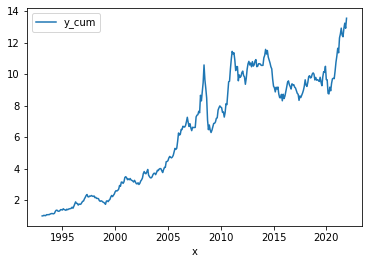

In [2236]:
positive_basis_momentum_carry_test.plot.line(x="x", y="y_cum")

In [2237]:
positive_basis_momentum_carry_test[["y"]].describe()

,y
count,347.000000
mean,1.008280
std,0.038696
min,0.835383
25%,0.983936
50%,1.006187
75%,1.033273
max,1.146835


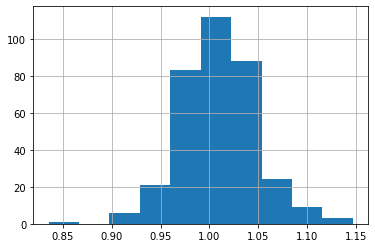

In [2238]:
positive_basis_momentum_carry_test["y"].hist()

Negative Momentum Test

In [2239]:
negative_basis_momentum_carry_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] <= 1/3
].copy()
negative_basis_momentum_carry_test["pick_adj_monthly_return"] = negative_basis_momentum_carry_test[[
    "adj_monthly_return",
   "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)
negative_basis_momentum_carry_test = negative_basis_momentum_carry_test.groupby(["Year", "Month"]).agg(y = ("pick_adj_monthly_return", "mean")).reset_index()

In [2240]:
negative_basis_momentum_carry_test["x"] = negative_basis_momentum_carry_test["Year"] + (negative_basis_momentum_carry_test["Month"] - 1) / 12

In [2241]:
negative_basis_momentum_carry_test[["x", "y"]]

,x,y
0,1993.083333,1.031277
1,1993.166667,1.027638
2,1993.250000,0.986280
3,1993.333333,0.969054
4,1993.416667,0.952148
...,...,...
342,2021.583333,1.023969
343,2021.666667,0.984118
344,2021.750000,0.978441
345,2021.833333,0.996796


In [2242]:
negative_basis_momentum_carry_test["y_cum"] = (2 - negative_basis_momentum_carry_test["y"]).cumprod()

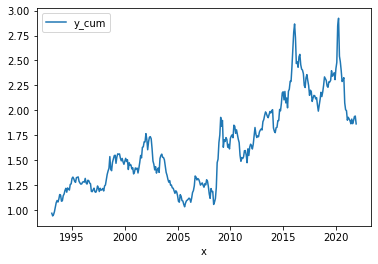

In [2243]:
negative_basis_momentum_carry_test.plot.line(x="x", y="y_cum")

In [2244]:
negative_basis_momentum_carry_test[["y"]].describe()

,y
count,347.000000
mean,0.997468
std,0.038549
min,0.794256
25%,0.975393
50%,0.998030
75%,1.020915
max,1.141615


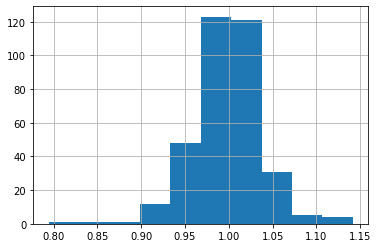

In [2245]:
negative_basis_momentum_carry_test["y"].hist()

Combined Momentum Test

In [2246]:
combined_basis_momentum_carry_test = negative_basis_momentum_carry_test[["x", "y"]].merge(positive_basis_momentum_carry_test[["x", "y"]], on="x")

In [2247]:
combined_basis_momentum_carry_test["y"] = (2 - combined_basis_momentum_carry_test["y_x"] + combined_basis_momentum_carry_test["y_y"]) / 2

In [2248]:
combined_basis_momentum_carry_test[["x", "y"]]

,x,y
0,1993.083333,0.989874
1,1993.166667,0.988825
2,1993.250000,1.024311
3,1993.333333,1.005959
4,1993.416667,1.022495
...,...,...
342,2021.583333,0.983835
343,2021.666667,1.029125
344,2021.750000,1.023808
345,2021.833333,0.989475


In [2249]:
combined_basis_momentum_carry_test["y_cum"] = combined_basis_momentum_carry_test["y"].cumprod()

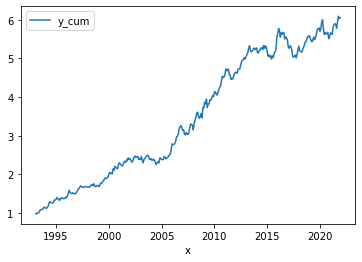

In [2250]:
combined_basis_momentum_carry_test.plot.line(x="x", y="y_cum")

In [2251]:
combined_basis_momentum_carry_test[["y"]].describe()

,y
count,347.000000
mean,1.005406
std,0.020311
min,0.945666
25%,0.992097
50%,1.005536
75%,1.017582
max,1.077710


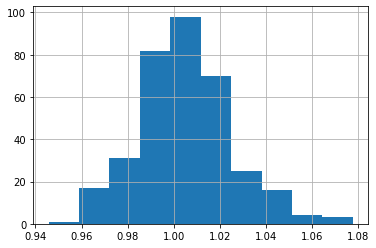

In [2252]:
combined_basis_momentum_carry_test["y"].hist()

## Value Test

Rank the value for each month so we can get the top & bottom percentiles

In [2253]:
backtest_data_value = backtest_data[~pd.isnull(backtest_data.value_signal)].copy()

In [2254]:
backtest_data_value

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,Carry Rank,Carry Rank Group,c1_c2_momentum_signal,Momentum Rank
66,C,1997,7,1,1997-07-01,248.50,238.00,-0.042254,0.997047,1.063998,...,295.040675,-7.035649,-0.043005,-6.689042,0.022085,-0.115842,0.166667,1,-6.862345,0.277778
67,C,1997,8,1,1997-08-01,265.00,267.00,0.007547,1.001887,1.006554,...,283.998016,-0.115449,-0.121166,3.624374,-0.106021,-0.084729,0.684211,6,1.754463,0.578947
68,C,1997,9,2,1997-09-02,265.50,268.75,0.012241,0.995707,1.006667,...,278.003968,0.084522,-0.140012,0.304606,-0.128946,-0.065617,0.736842,7,0.194564,0.473684
69,C,1997,10,1,1997-10-01,257.50,266.50,0.034951,1.086408,1.085366,...,273.485119,-0.234639,-0.128345,0.574452,-0.139032,-0.008202,0.900000,9,0.169907,0.600000
70,C,1997,11,3,1997-11-03,279.75,289.25,0.033959,0.969616,0.970614,...,273.650794,5.247790,-0.219570,5.431540,-0.228927,-0.008770,0.900000,9,5.339665,0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.703704,7,-5.243299,0.111111
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.851852,8,0.582463,0.555556
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.851852,8,-1.822264,0.481481
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.851852,8,4.420591,0.740741


In [2255]:
backtest_data_value["c1_c2_value_signal"] = (backtest_data_value["value_signal"] + backtest_data_value["c2_value_signal"]) / 2
backtest_data_value["Value Rank"] = backtest_data_value.groupby(["Year", "Month"])["c1_c2_value_signal"].rank("average", ascending=True,pct=True)

In [2256]:
backtest_data_value[backtest_data_value["Value Rank"] >= 2/3].adj_monthly_return.product() - 1

834.1664201782403

In [2257]:
backtest_data_value[backtest_data_value["Value Rank"] <= 1/3].adj_monthly_return.product() - 1

-0.8573351429105511

Positive Value Test

In [2258]:
positive_value_test = backtest_data_value[
    backtest_data_value["Value Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("adj_monthly_return", "mean")).reset_index()

In [2259]:
positive_value_test["x"] = positive_value_test["Year"] + (positive_value_test["Month"] - 1) / 12

In [2260]:
positive_value_test[["x", "y"]]

,x,y
0,1997.500000,1.053600
1,1997.583333,0.966751
2,1997.666667,1.027404
3,1997.750000,0.972897
4,1997.833333,0.959697
...,...,...
289,2021.583333,1.040431
290,2021.666667,0.984052
291,2021.750000,0.996471
292,2021.833333,0.982720


In [2261]:
positive_value_test["y_cum"] = positive_value_test["y"].cumprod()

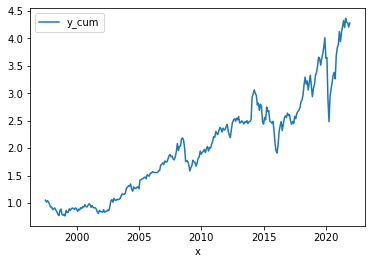

In [2262]:
positive_value_test.plot.line(x="x", y="y_cum")

In [2263]:
positive_value_test[["y"]].describe()

,y
count,294.000000
mean,1.005968
std,0.044940
min,0.789347
25%,0.981627
50%,1.007821
75%,1.031126
max,1.184831


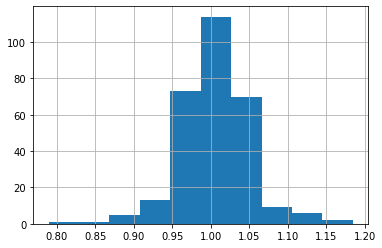

In [2264]:
positive_value_test["y"].hist()

Negative Value Test

In [2265]:
negative_value_test = backtest_data_value[
    backtest_data_value["Value Rank"] <= 1/3
].groupby(["Year", "Month"]).agg(y = ("adj_monthly_return", "mean")).reset_index()

In [2266]:
negative_value_test["x"] = negative_value_test["Year"] + (negative_value_test["Month"] - 1) / 12

In [2267]:
negative_value_test[["x", "y"]]

,x,y
0,1997.500000,0.994577
1,1997.583333,0.990811
2,1997.666667,0.968856
3,1997.750000,0.991536
4,1997.833333,0.990388
...,...,...
289,2021.583333,1.001915
290,2021.666667,1.011672
291,2021.750000,1.009841
292,2021.833333,0.979838


In [2268]:
negative_value_test["y_cum"] = (2 - negative_value_test["y"]).cumprod()

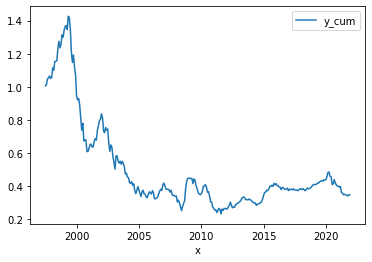

In [2269]:
negative_value_test.plot.line(x="x", y="y_cum")

In [2270]:
negative_value_test[["y"]].describe()

,y
count,294.000000
mean,1.002510
std,0.047013
min,0.762373
25%,0.979185
50%,0.999910
75%,1.024367
max,1.137322


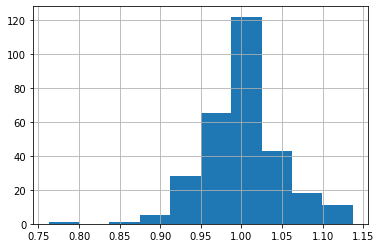

In [2271]:
negative_value_test["y"].hist()

Combined Value Test

In [2272]:
combined_value = negative_value_test[["x", "y"]].merge(positive_value_test[["x", "y"]], on="x")

In [2273]:
combined_value["y"] = (2 - combined_value["y_x"] + combined_value["y_y"]) / 2

In [2274]:
combined_value[["x", "y"]]

,x,y
0,1997.500000,1.029511
1,1997.583333,0.987970
2,1997.666667,1.029274
3,1997.750000,0.990681
4,1997.833333,0.984655
...,...,...
289,2021.583333,1.019258
290,2021.666667,0.986190
291,2021.750000,0.993315
292,2021.833333,1.001441


In [2275]:
combined_value["y_cum"] = combined_value["y"].cumprod()

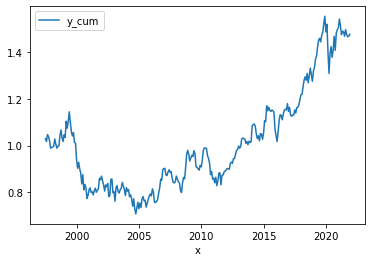

In [2276]:
combined_value.plot.line(x="x", y="y_cum")

In [2277]:
combined_value[["y"]].describe()

,y
count,294.000000
mean,1.001729
std,0.028408
min,0.923105
25%,0.982585
50%,1.003178
75%,1.020692
max,1.087281


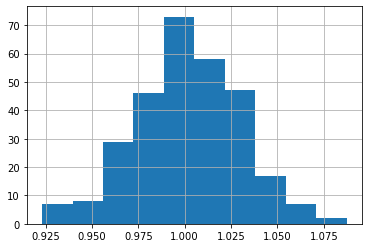

In [2278]:
combined_value["y"].hist()

## Value-Carry

Rank the value for each month so we can get the top & bottom percentiles

In [2279]:
backtest_data_value = backtest_data[~pd.isnull(backtest_data.value_signal)].copy()

In [2280]:
backtest_data_value

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,Carry Rank,Carry Rank Group,c1_c2_momentum_signal,Momentum Rank
66,C,1997,7,1,1997-07-01,248.50,238.00,-0.042254,0.997047,1.063998,...,295.040675,-7.035649,-0.043005,-6.689042,0.022085,-0.115842,0.166667,1,-6.862345,0.277778
67,C,1997,8,1,1997-08-01,265.00,267.00,0.007547,1.001887,1.006554,...,283.998016,-0.115449,-0.121166,3.624374,-0.106021,-0.084729,0.684211,6,1.754463,0.578947
68,C,1997,9,2,1997-09-02,265.50,268.75,0.012241,0.995707,1.006667,...,278.003968,0.084522,-0.140012,0.304606,-0.128946,-0.065617,0.736842,7,0.194564,0.473684
69,C,1997,10,1,1997-10-01,257.50,266.50,0.034951,1.086408,1.085366,...,273.485119,-0.234639,-0.128345,0.574452,-0.139032,-0.008202,0.900000,9,0.169907,0.600000
70,C,1997,11,3,1997-11-03,279.75,289.25,0.033959,0.969616,0.970614,...,273.650794,5.247790,-0.219570,5.431540,-0.228927,-0.008770,0.900000,9,5.339665,0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.703704,7,-5.243299,0.111111
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.851852,8,0.582463,0.555556
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.851852,8,-1.822264,0.481481
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.851852,8,4.420591,0.740741


In [2281]:
backtest_data_value["c1_c2_value_signal"] = (backtest_data_value["value_signal"] + backtest_data_value["c2_value_signal"]) / 2
backtest_data_value["Value Rank"] = backtest_data_value.groupby(["Year", "Month"])["c1_c2_value_signal"].rank("average", ascending=True,pct=True)

In [2282]:
backtest_data_value[backtest_data_value["Value Rank"] >= 2/3].adj_monthly_return.product() - 1

834.1664201782403

In [2283]:
backtest_data_value[backtest_data_value["Value Rank"] <= 1/3].adj_monthly_return.product() - 1

-0.8573351429105511

Positive Value Test

In [2284]:
positive_value_carry_test = backtest_data_value[
    backtest_data_value["Value Rank"] >= 2/3
].copy()
positive_value_carry_test["pick_adj_monthly_return"] = positive_value_carry_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)
positive_value_carry_test = positive_value_carry_test.groupby(["Year", "Month"]).agg(y = ("pick_adj_monthly_return", "mean")).reset_index()

In [2285]:
positive_value_carry_test["x"] = positive_value_carry_test["Year"] + (positive_value_carry_test["Month"] - 1) / 12

In [2286]:
positive_value_carry_test[["x", "y"]]

,x,y
0,1997.500000,1.053600
1,1997.583333,0.967950
2,1997.666667,1.027404
3,1997.750000,0.978417
4,1997.833333,0.961172
...,...,...
289,2021.583333,1.038966
290,2021.666667,0.986451
291,2021.750000,0.998585
292,2021.833333,0.985207


In [2287]:
positive_value_carry_test["y_cum"] = positive_value_carry_test["y"].cumprod()

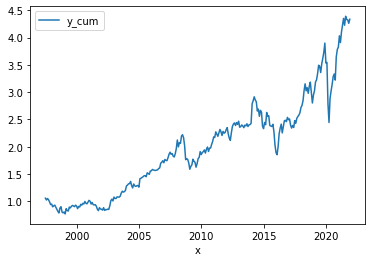

In [2288]:
positive_value_carry_test.plot.line(x="x", y="y_cum")

In [2289]:
positive_value_carry_test[["y"]].describe()

,y
count,294.000000
mean,1.005990
std,0.044437
min,0.786382
25%,0.980906
50%,1.007756
75%,1.031758
max,1.180395


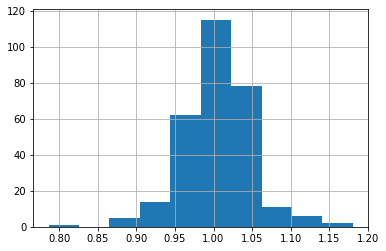

In [2290]:
positive_value_carry_test["y"].hist()

Negative Value Test

In [2291]:
negative_value_carry_test = backtest_data_value[
    backtest_data_value["Value Rank"] <= 1/3
].copy()
negative_value_carry_test["pick_adj_monthly_return"] = negative_value_carry_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)
negative_value_carry_test = negative_value_carry_test.groupby(["Year", "Month"]).agg(y = ("pick_adj_monthly_return", "mean")).reset_index()

In [2292]:
negative_value_carry_test["x"] = negative_value_carry_test["Year"] + (negative_value_carry_test["Month"] - 1) / 12

In [2293]:
negative_value_carry_test[["x", "y"]]

,x,y
0,1997.500000,0.991423
1,1997.583333,0.980594
2,1997.666667,0.971705
3,1997.750000,0.993540
4,1997.833333,0.991145
...,...,...
289,2021.583333,1.003085
290,2021.666667,1.012708
291,2021.750000,1.010720
292,2021.833333,0.979394


In [2294]:
negative_value_carry_test["y_cum"] = (2 - negative_value_carry_test["y"]).cumprod()

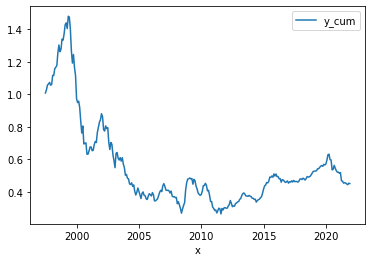

In [2295]:
negative_value_carry_test.plot.line(x="x", y="y_cum")

In [2296]:
negative_value_carry_test[["y"]].describe()

,y
count,294.000000
mean,1.001604
std,0.046838
min,0.767218
25%,0.976914
50%,0.998030
75%,1.025047
max,1.137531


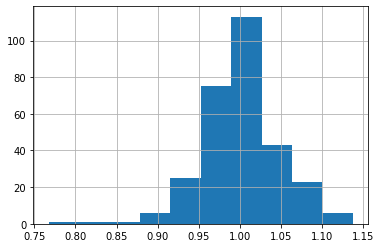

In [2297]:
negative_value_carry_test["y"].hist()

Combined Value Test

In [2298]:
combined_value_carry_test = negative_value_carry_test[["x", "y"]].merge(positive_value_carry_test[["x", "y"]], on="x")

In [2299]:
combined_value_carry_test["y"] = (2 - combined_value_carry_test["y_x"] + combined_value_carry_test["y_y"]) / 2

In [2300]:
combined_value_carry_test[["x", "y"]]

,x,y
0,1997.500000,1.031089
1,1997.583333,0.993678
2,1997.666667,1.027850
3,1997.750000,0.992438
4,1997.833333,0.985013
...,...,...
289,2021.583333,1.017940
290,2021.666667,0.986871
291,2021.750000,0.993933
292,2021.833333,1.002907


In [2301]:
combined_value_carry_test["y_cum"] = combined_value_carry_test["y"].cumprod()

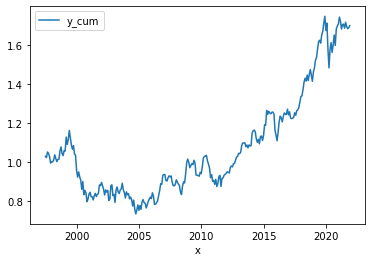

In [2302]:
combined_value_carry_test.plot.line(x="x", y="y_cum")

In [2303]:
combined_value_carry_test[["y"]].describe()

,y
count,294.000000
mean,1.002193
std,0.027744
min,0.921168
25%,0.984230
50%,1.003791
75%,1.020317
max,1.085046


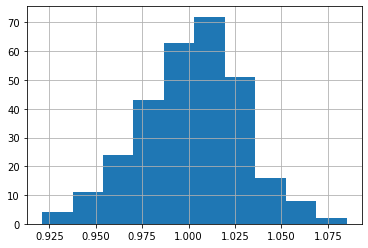

In [2304]:
combined_value_carry_test["y"].hist()

# Output Plots

In [2316]:
combined_carry_test.to_csv("combined_carry_test.csv", index=False)
ew_commodity_test.to_csv("ew_test.csv", index=False)
combined_momentum_test.to_csv("combined_momentum_test.csv", index=False)
combined_carry_momentum_v3_test.to_csv("combined_carry_momentum_v3_test.csv", index=False)
combined_basis_momentum_test.to_csv("combined_basis_momentum_test.csv", index=False)
combined_basis_momentum_carry_test.to_csv("combined_basis_momentum_carry_test.csv", index=False)
combined_value.to_csv("combined_value_test.csv", index=False)
combined_value_carry_test.to_csv("combined_value_carry_test.csv", index=False)

In [2306]:
import matplotlib.pyplot as plt
import numpy as np

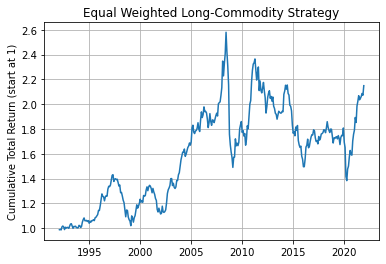

In [2307]:
fig, ax = plt.subplots()
ax.plot(ew_commodity_test["x"], ew_commodity_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Equal Weighted Long-Commodity Strategy')

ax.grid()

fig.savefig("ew_long_commodity_cum_return.png")
plt.show()

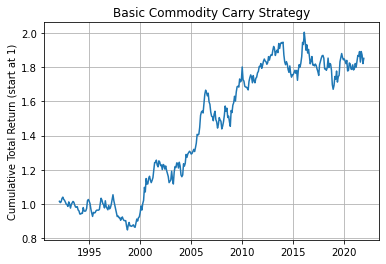

In [2308]:
fig, ax = plt.subplots()
ax.plot(combined_carry_test["x"], combined_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Carry Strategy')

ax.grid()

fig.savefig("basic_carry_cum_return.png")
plt.show()

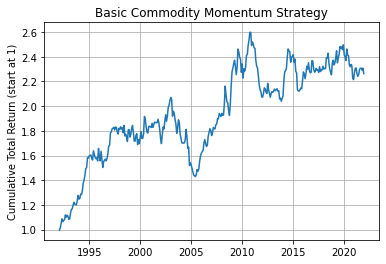

In [2309]:
fig, ax = plt.subplots()
ax.plot(combined_momentum_test["x"], combined_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Momentum Strategy')

ax.grid()

fig.savefig("basic_momentum_cum_return.png")
plt.show()

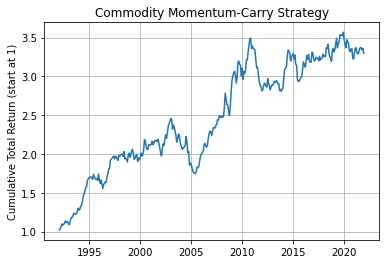

In [2310]:
fig, ax = plt.subplots()
ax.plot(combined_carry_momentum_v3_test["x"], combined_carry_momentum_v3_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Momentum-Carry Strategy')

ax.grid()

fig.savefig("momentum_carry_cum_return.png")
plt.show()

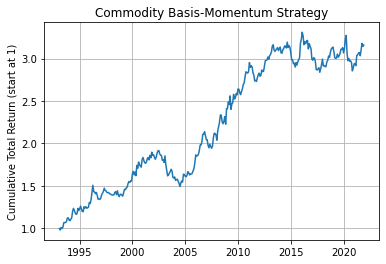

In [2311]:
fig, ax = plt.subplots()
ax.plot(combined_basis_momentum_test["x"], combined_basis_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Basis-Momentum Strategy')

ax.grid()

fig.savefig("basis_momentum_cum_return.png")
plt.show()

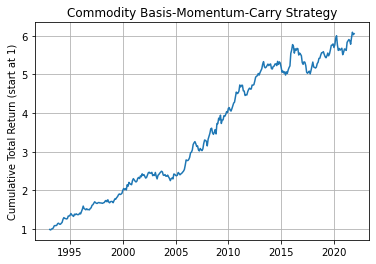

In [2312]:
fig, ax = plt.subplots()
ax.plot(combined_basis_momentum_carry_test["x"], combined_basis_momentum_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Basis-Momentum-Carry Strategy')

ax.grid()

fig.savefig("basis_momentum_carry_cum_return.png")
plt.show()

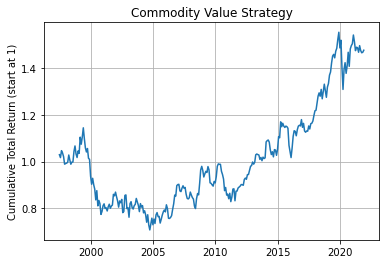

In [2313]:
fig, ax = plt.subplots()
ax.plot(combined_value["x"], combined_value["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Value Strategy')

ax.grid()

fig.savefig("value_cum_return.png")
plt.show()

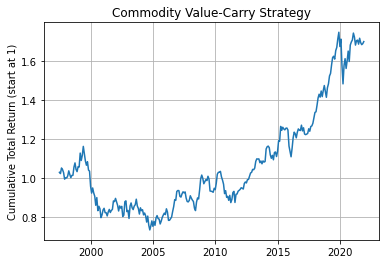

In [2314]:
fig, ax = plt.subplots()
ax.plot(combined_value_carry_test["x"], combined_value_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Value-Carry Strategy')

ax.grid()

fig.savefig("value_carry_cum_return.png")
plt.show()